In [1]:
import sys
sys.path.append('..')
import numpy as np
from common import config

config.GPU = True

import pickle
from common.trainer import Trainer
from common.optimizer import Adam

from common.util import *
from common.layers import *

from common.np import *  # import numpy as np
from dataset import ptb
import collections


------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [3]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [4]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dout_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dout_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 正例
        score = self.embed_dout_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 負例
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dout_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss        
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dout_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

In [5]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(V, H).astype("f")
        
        # レイヤーの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0/75, sample_size=5)
        
        # すべての重みと勾配を配列にまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 /len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [6]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

In [7]:
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

In [8]:
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [9]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot

| epoch 1 |  iter 1 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 1[s] | loss 3.89
| epoch 1 |  iter 121 / 9295 | time 2[s] | loss 3.69
| epoch 1 |  iter 141 / 9295 | time 2[s] | loss 3.45
| epoch 1 |  iter 161 / 9295 | time 2[s] | loss 3.19
| epoch 1 |  iter 181 / 9295 | time 2[s] | loss 2.94
| epoch 1 |  iter 201 / 9295 | time 2[s] | loss 2.69
| epoch 1 |  iter 221 / 9295 | time 2[s] | loss 2.46
| epoch 1 |  iter 241 / 9295 | time 2[s] | loss 2.28
| epoch 1 |  iter 261 / 9295 | time 3[s] | loss 2.16
| epoch 1 |  iter 281 / 9295 | time 3[s] | loss 1.98
| epoch 1 |  iter 301 / 9295 | time 3[s] | loss 1.90
| epoch 1 |  iter 321 / 9295 | time 3[s] | loss 1.81
| epoch 1 |  iter 341 / 9295 | time 3[s] | loss 1.71
| epoch 1 |  iter 361 / 9295 | time 3[s] | loss 1.69

<bound method Trainer.plot of <common.trainer.Trainer object at 0x0000016049721810>>

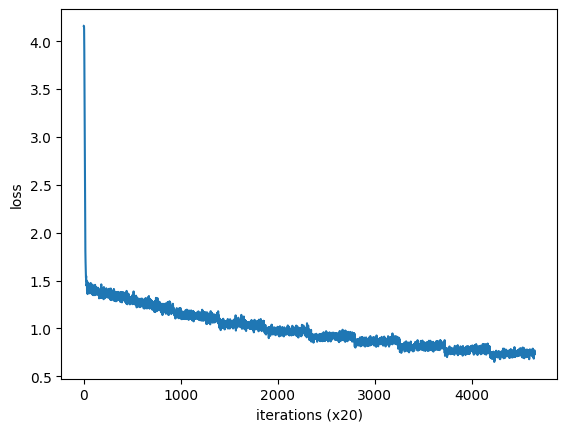

In [16]:

trainer.plot()

In [10]:
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params["word_vecs"] = word_vecs.astype(np.float16)
params["word_to_id"] = word_to_id
params["id_to_word"] = id_to_word
pkl_file = "cbow_params.pkl"
with open(pkl_file, "wb") as f:
    pickle.dump(params, f, -1)